In [ ]:
import io
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Introduction to the Task

The goal of this code is to develop an LSTM model for text generation, specifically for next character prediction in a text. The model is trained on Dante's Divine Comedy. This task presents some challenges, particularly due to the significant syntactic diversity across the three parts of the Divine Comedy—Inferno, Purgatorio, and Paradiso—resulting from the evolution of poetic language and Dante's stylistic choices to reflect the themes and tones of each cantica. Below are some key aspects of these differences:

Syntactic Complexity:
- **Inferno**: The syntax is simpler and more direct, often paratactic (coordinated sentences), reflecting the harshness and brutality of the described setting. This fosters a faster-paced and more dramatic narrative rhythm.
- **Purgatorio**: The syntax becomes increasingly complex, balancing parataxis and hypotaxis (use of subordinate clauses), reflecting the journey toward purification and a more contemplative tone.
- **Paradiso**: The syntax is highly complex, with frequent use of hypotaxis and elevated linguistic constructions. This complexity underscores the sublimity and ineffability of the divine visions.
The poem is divided into three sections, called "cantiche" (Inferno, Purgatorio, Paradiso), each consisting of 33 cantos (except for Inferno, which contains an additional prologue canto). Each canto is made up of a variable number of verses, ranging from 115 to 160, structured in tercets.

The **code is organized** as follows:

- Division of the Divine Comedy into training and validation sets.
- Modification of the initial network architecture to improve performance.
- Fine-tuning of the chunk length.
- Identification of the optimal model and testing it on a text different from the Divine Comedy but with a similar linguistic style.

Each model built was evaluated in terms of prediction accuracy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
print('opening file...')
path = '/content/drive/MyDrive/divina_commedia.txt'
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('text length:', len(text))
print()
print('\n\n\n\n\n', '****** first 1000 characters *******', '\n\n\n\n')
text[0:1000]


opening file...
text length: 558240






 ****** first 1000 characters ******* 






"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

In [ ]:
chars = sorted(list(set(text)))
print('total chars: ', len(chars))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(char_indices)
print(indices_char)

total chars:  40
{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


The text is divided into overlapping sequences of fixed length (`maxlen`), advancing by `step` characters. For each generated sequence, the immediately following character is identified, creating two lists: `sentences`, containing the extracted sequences, and `next_chars`, containing the associated target characters.

In [ ]:
maxlen = 30 # chunk length
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('number of sequences: ', len(sentences))
print(sentences[11])
print(next_chars[11])

number of sequences:  186070
 mezzo del cammin di nostra vi
t


 The preprocessed text sequences (`sentences`)  and the target characters (`next_chars`) are converted into one-hot representations for training a model. The three-dimensional tensor `x` represents the input with dimensions `(number of sequences, sequence length, vocabulary size)`, while `y` is a two-dimensional tensor representing the next target characters in one-hot format with dimensions `(number of sequences, vocabulary size)`.

In [ ]:
print('generating input and output...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print(x.shape)
print(y.shape)

generating input and output...
(186070, 30, 40)
(186070, 40)


The initial model consists of:
- **LSTM Layer:**  
  An LSTM layer with 128 units, which takes input sequences of length `maxlen` and a vocabulary of size `len(chars)`. The LSTM is designed to capture long-term temporal dependencies in the text sequences.

- **Fully Connected Layer:**  
  A dense layer with a number of neurons equal to the vocabulary size (`len(chars)`), using the softmax activation function. This layer outputs a probability distribution over the possible classes (next characters).

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import sys
def testAfterEpoch(epoch, _):
  print()
  print()
  print('******* Epoch: %d ********' % (epoch+1))
  start_index = random.randint(0, len(text)-maxlen-1)

  generated = ''
  sentence = text[start_index :  start_index + maxlen]
  generated = generated + sentence

  print('***** starting sentence *****')
  print(sentence)
  print('*****************************')
  sys.stdout.write(generated)

  for i in range(400):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()

In [ ]:
print_callback = LambdaCallback(on_epoch_end=testAfterEpoch)

In [ ]:
model.fit(x, y,
          batch_size = 2048,
          epochs = 20,
          callbacks = [print_callback])

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0928

******* Epoch: 1 ********
***** starting sentence *****
o i nostri corpi appesi,
  cia
*****************************
o i nostri corpi appesi,
  cia che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si che si 
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - loss: 2.0922
Epoch 2/20
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8945

******* Epoch: 2 ********
***** starting sentence *****
he di la` piagne,
  perche' si
*****************************
he di la` piagne,
  perche' si` che l'altro di la suo di la suo di la suo di la suo di la suo di la suo di la suo di la suo di la suo di la suo 

The model tends to repeat itself frequently after generating a sentence. The repetition issue may originate from **cumulative error**, where the model, using its own generated characters as subsequent inputs, progressively amplifies initial errors, losing the original context.

# Split Training e Validation

Given the structure of the *Divine Comedy* described above, where the three cantiche have different syntactic structures, the training and validation sets were divided as follows: since the *Divine Comedy* consists of a total of 100 cantos (34 from Inferno, 33 from Purgatorio, and 33 from Paradiso), the goal was to split 80% for training and 20% for validation. For training, the following cantos were used:
* 27 cantos from Inferno
* 26 cantos from Purgatorio
* 26 cantos from Paradiso

The remaining cantos were used for validation, in order to diversify as much as possible and ensure that the validation set includes examples from all three cantiche, allowing the model to be tested on a diverse range of syntactic and stylistic variations representative of the entire Divine Comedy

In [ ]:
import re

pattern = r'(inferno: canto [ivxlcdm]+|purgatorio: canto [ivxlcdm]+|paradiso: canto [ivxlcdm]+)'
canti = re.split(pattern, text)

canti = [canti[i] + canti[i + 1] for i in range(1, len(canti) - 1, 2)]

print(f"Total canti: {len(canti)}")

Total canti: 100


In [ ]:
inferno = canti[:34]
purgatorio = canti[34:67]
paradiso = canti[67:]

training_canti = (
    inferno[:27] +
    purgatorio[:26] +
    paradiso[:26]
)
validation_canti = (
    inferno[27:] +
    purgatorio[26:] +
    paradiso[26:]
)

In [ ]:
print(f"Total training canti: {len(training_canti)}")
print(f"Total validation canti: {len(validation_canti)}")

Total training canti: 79
Total validation canti: 21


In [ ]:
training_text = '\n'.join(training_canti)
validation_text = '\n'.join(validation_canti)

In [ ]:
maxlen = 30
step = 3

In [ ]:
sentences_train = []
next_chars_train = []

for i in range(0, len(training_text) - maxlen, step):
    sentences_train.append(training_text[i: i + maxlen])
    next_chars_train.append(training_text[i + maxlen])

sentences_val = []
next_chars_val = []

for i in range(0, len(validation_text) - maxlen, step):
    sentences_val.append(validation_text[i: i + maxlen])
    next_chars_val.append(validation_text[i + maxlen])


In [ ]:
def vectorize_data(sentences, next_chars, char_indices, maxlen, len_chars):
    x = np.zeros((len(sentences), maxlen, len_chars), dtype=bool)
    y = np.zeros((len(sentences), len_chars), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

x_train, y_train = vectorize_data(sentences_train, next_chars_train, char_indices, maxlen, len(chars))
x_val, y_val = vectorize_data(sentences_val, next_chars_val, char_indices, maxlen, len(chars))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(146094, 30, 40)
(146094, 40)
(39996, 30, 40)
(39996, 40)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, BatchNormalization
import tensorflow as tf
from keras import metrics as kmetrics


# Network Architecture and Improvements

## Second Model

The model is modified to implement not only an LSTM layer but also a BiLSTM layer. In a deep learning model, a bidirectional LSTM (BiLSTM) operation learns long-term dependencies in both forward and backward directions across time steps in time series or sequence data. These bidirectional dependencies are valuable when the model needs to learn from the entire sequence at each time step.

Specifically a **BiLSTM** consists of two LSTM components: the **forward LSTM**, which processes the data from the first time step to the last, and the **backward LSTM**, which processes the data from the last time step to the first. After passing the data through both LSTM components, the outputs are concatenated along the channel dimension. This approach should enhances the model's ability to understand the full context, improving the quality of the predictions.

The model is also modified to include a 20% Dropout layer in order to mitigate overfitting on the data.

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen, len(chars))))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 256)             │         173,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 375,336 (1.43 MB)

 Trainable params: 375,336 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1539 - loss: 3.1301

******* Epoch: 1 ********
***** starting sentence *****

esser di marmo candido e addo
*****************************

esser di marmo candido e addo co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co co 
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 430ms/step - accuracy: 0.1548 - loss: 3.1238 - val_accuracy: 0.2643 - val_loss: 2.4420
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2714 - loss: 2.3879

******* Epoch: 2 ********
***** starting sentence *****
 albia in mar ne porta:

ottac
*****************************
 albia in mar ne porta:

ottacuor suarto,

  

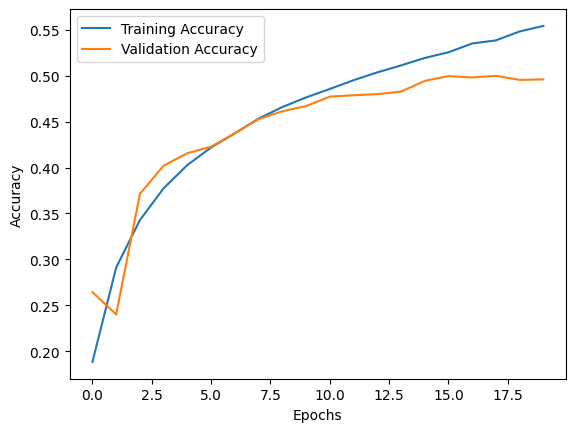

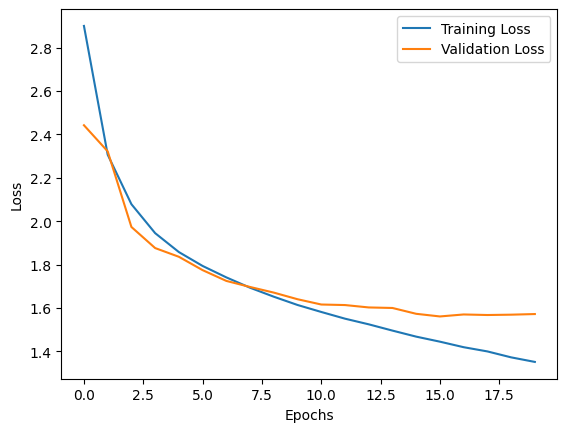

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

There is significant overfitting in the model, as evidenced by a large gap between the training and validation performance. The validation loss became lower than the training loss around the 6th epoch, but it remained very high overall. This indicates that the model has poor generalization capability, as it is overfitting to the training data and failing to effectively learn patterns that can be applied to unseen data.

## Third Model

A new model is implemented with the following modifications:

- **Increased Dropout to 30%**: This is done to further reduce overfitting by randomly setting a higher percentage of input units to zero during training, forcing the model to learn more robust features.
  
- **Added BatchNormalization**: Batch normalization is introduced to reduce the variation in activation values across different batches, which helps stabilize and accelerate training. This can improve the effectiveness of dropout by maintaining more consistent distributions of the activations.

Regarding evaluation metrics:

- **Character Frequency**: Some characters (like spaces, vowels, or punctuation marks) are much more frequent than others. The model can achieve decent accuracy by predicting these frequent characters most of the time, even if it performs poorly on less frequent ones. This can mislead the evaluation, as the model may not be capturing the full diversity of the language.
  
- **Accuracy Limitations**: Accuracy alone doesn’t reflect how well the model captures the underlying structure, grammar, or poetic style of the *Divine Comedy*. A model could achieve high accuracy by memorizing common character sequences, yet still fail to generalize and generate text that resembles the original style.

To address these issues, **precision** and **recall** are also added as metrics to track during training. These metrics give a better understanding of the model's performance, particularly in how well it identifies less frequent characters and its ability to generate meaningful and diverse text.

In [ ]:
model = Sequential()
model.add(Input(shape=(maxlen, len(chars))))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(chars), activation='softmax'))


optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                             kmetrics.Precision(name="precision"),
                                                                             kmetrics.Recall(name="recall")])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 30, 256)             │         173,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 376,872 (1.44 MB)

 Trainable params: 376,104 (1.43 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2267 - loss: 2.8885 - precision: 0.4781 - recall: 0.0663

******* Epoch: 1 ********
***** starting sentence *****
ta in giuso.

'adhaesit pavime
*****************************
ta in giuso.

'adhaesit pavime                                                                                                                                                                                                                                                                                                                                                                                                                
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - accuracy: 0.2285 - loss: 2.8751 - precision: 0.4817 - recall: 0.0674 - val_accuracy: 0.1820 - val_loss: 2.9688 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3677 - loss: 1.9778 - precision: 0.7011 - recall: 0.1765

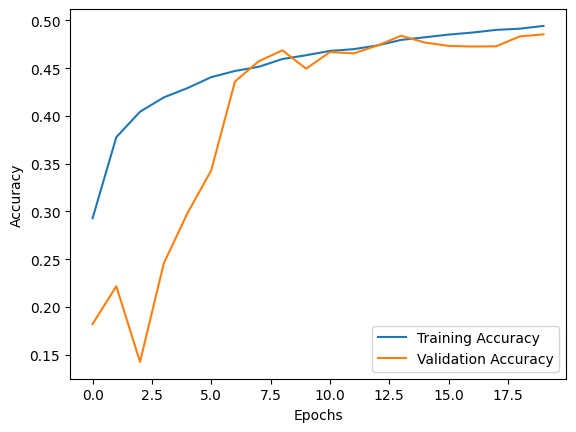

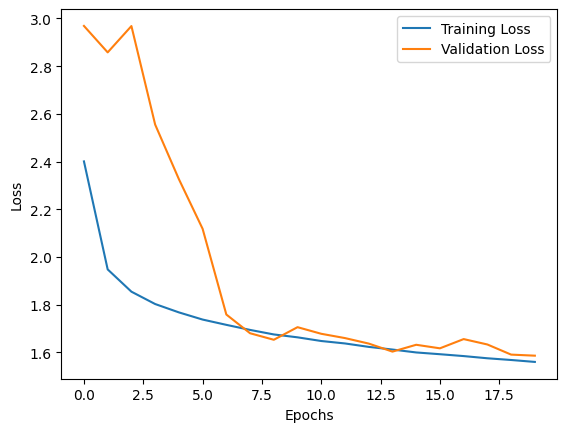

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In the later epochs, the gap between training and validation appears to have improved. However, the addition of batch normalization and the increase in dropout have caused the model to fluctuate, particularly in terms of validation performance.

The accuracy steadily improves, rising from approximately 22.85% in Epoch 1 to about 46.45% in Epoch 10. The loss consistently decreases, suggesting that the model is learning patterns effectively. Validation accuracy shows a similar trend, increasing from around 18.2% in Epoch 1 to 46.86% by Epoch 9. However, it slightly drops to 44.94% in Epoch 10. Similarly, validation loss decreases until Epoch 9 but begins to increase in Epoch 10, indicating signs of potential overfitting.

Additionally, recall grows from around 6.63% to 28.47%, indicating that the model is progressively identifying more true positives over time, but it is sill low: the model finds only about 32.9% of the correct characters, even though on validation data, it improves slightly to 33.4%.

The precision is quite high (76.75%), but given the other metrics, it could be caused by the fact that the model predicts only a small portion of the correct characters, most likely the most common ones.




## Fourth model

In [ ]:
from keras.layers import Embedding

I also use **Perplexity** as a metric, which measures the probability error in discrete classification tasks, in other words Perplexity measures how uncertain a model is about its prediction. It is calculated as the exponent of the average cross-entropy loss.

The formula for Perplexity is:

$$ \text{Perplexity} = \exp\left(\frac{1}{N} \sum_{i=1}^N \text{CrossEntropy}(y_{\text{true}}, y_{\text{pred}})\right) $$

Here, `tf.nn.softmax_cross_entropy_with_logits` computes the cross-entropy, and `tf.exp(tf.reduce_mean(...))` applies the exponential function to the mean to obtain the Perplexity. A lower Perplexity indicates better model accuracy and confidence in its predictions.


In [ ]:
def perplexity(y_true, y_pred):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    perplexity_value = tf.exp(tf.reduce_mean(cross_entropy))
    return perplexity_value

Increasing the number of LSTM units can capture more complex patterns in the data, especially useful for long sequences or sequences with rich features but on the other hand this can lead to a higher risk of overfitting, which is why Dropout is added.

In [ ]:
model = Sequential([
    Input(shape=(maxlen, len(chars))),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(len(chars), activation='softmax')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                             kmetrics.Precision(name="precision"),
                                                                             kmetrics.Recall(name="recall"),
                                                                             perplexity])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 30, 512)             │         608,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405,992 (5.36 MB)

 Trainable params: 1,405,992 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.1450 - loss: 3.2851 - perplexity: 38.3625 - precision: 0.1733 - recall: 0.0086

******* Epoch: 1 ********
***** starting sentence *****
maggi
  lumi biancheggia tra '
*****************************
maggi
  lumi biancheggia tra ' sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de sse de 
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 582ms/step - accuracy: 0.1453 - loss: 3.2817 - perplexity: 38.3582 - precision: 0.1735 - recall: 0.0085 - val_accuracy: 0.2243 - val_loss: 2.8330 - val_perplexity: 37.8263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/ste

The training process shows some improvements. The model's perplexity improved substantially from 38.36 (epoch 1) to 27.30. A lower perplexity indicates that the model is becoming more confident and less uncertain about the next token prediction.

Recall has also increased compared to the previous model, reaching 35.47% on the validation set.

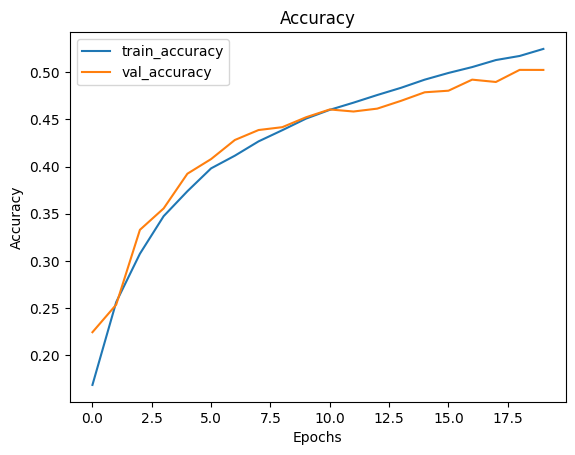

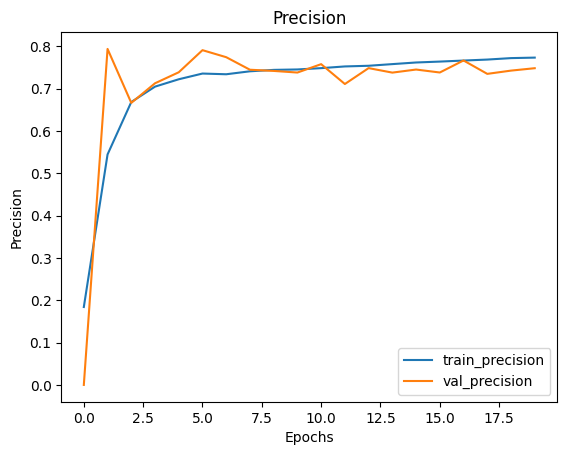

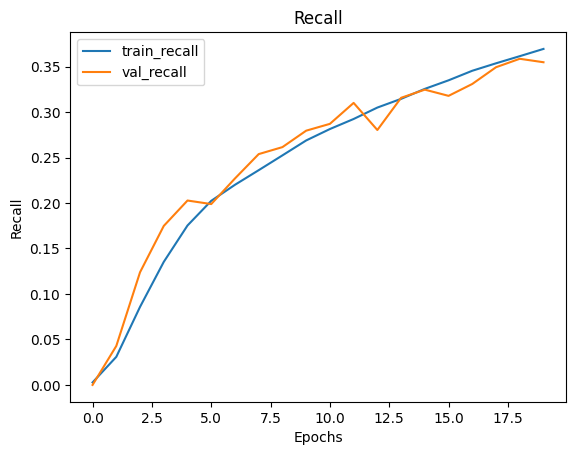

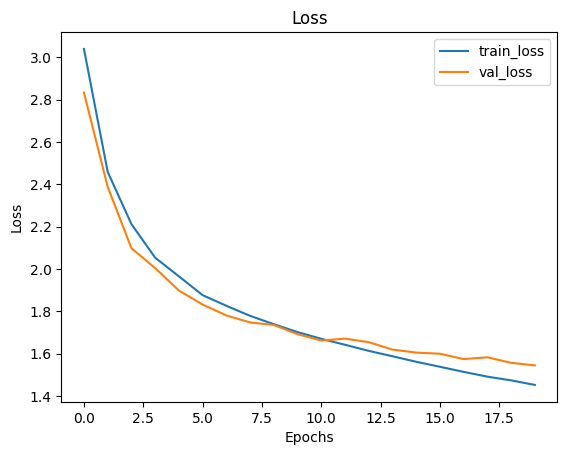

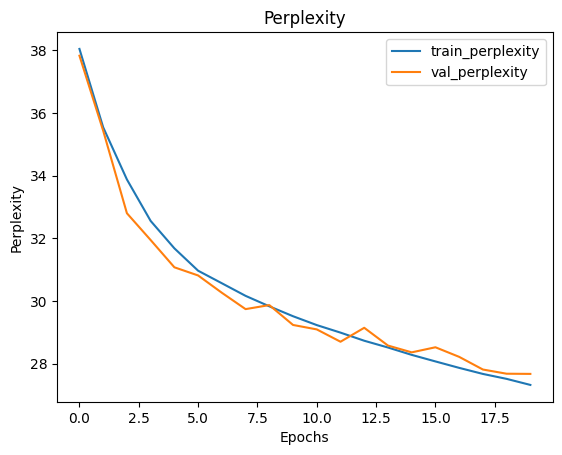

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'loss', 'perplexity']

    for metric in metrics:
        plt.plot(history.history[metric], label=f"train_{metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f"{metric.capitalize()}")
        plt.show()

plot_metrics(history)

The model is slightly overfitting, but the loss is very low, making it the best model evaluated so far.

We will try to optimize other parameters while keeping the structure unchanged to improve the model's loss and generalization capability.

# Optimizing Chunk Length

It would be important to consider the structure of the text. The Divine Comedy is written in tercets (three-line stanzas), each of which forms a natural linguistic unit. Using tercets as chunks, instead of arbitrary fixed lengths like 30, could help the model better capture context and rhythm.

Key Adjustments:
- Chunk Length (`maxlen`):
Since each triplet corresponds to three lines, determine the average length of three hendecasyllabic lines (in characters).
Let’s assume 11 syllables per line translates to approximately 33–45 characters per line, so a triplet could be roughly 100–135 characters. Set `maxlen` accordingly.
- `Step`:
To retain overlap and coherence between the chunks, step can be set to a value like 1/3 of maxlen, allowing the model to learn both intra-triplet and inter-triplet dependencies.

In [ ]:
maxlen = 120
step = 40

In [ ]:
sentences_train = []
next_chars_train = []

for i in range(0, len(training_text) - maxlen, step):
    sentences_train.append(training_text[i: i + maxlen])
    next_chars_train.append(training_text[i + maxlen])

In [ ]:
for i, sequence in enumerate(sentences_train[:5]):
    print(f"Sequence {i+1}:\n{sequence}\nNext char: {next_chars_train[i]}\n")


Sequence 1:
inferno: canto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smar
Next char: r

Sequence 2:
di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa
Next char:  

Sequence 3:
va oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e f
Next char: o

Sequence 4:
rita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

Next char: 


Sequence 5:
 dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
 
Next char:  



In [ ]:
sentences_val = []
next_chars_val = []

for i in range(0, len(validation_text) - maxlen, step):
    sentences_val.append(validation_text[i: i + maxlen])
    next_chars_val.append(validation_text[i + maxlen])

In [ ]:
def vectorize_data(sentences, next_chars, char_indices, maxlen, len_chars):
    x = np.zeros((len(sentences), maxlen, len_chars), dtype=bool)
    y = np.zeros((len(sentences), len_chars), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

x_train, y_train = vectorize_data(sentences_train, next_chars_train, char_indices, maxlen, len(chars))
x_val, y_val = vectorize_data(sentences_val, next_chars_val, char_indices, maxlen, len(chars))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(10955, 120, 40)
(10955, 40)
(2998, 120, 40)
(2998, 40)


Regarding the structure, increasing the dropout of the last layer could help reduce overfitting.

In [ ]:
model = Sequential([
    Input(shape=(maxlen, len(chars))),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.3),
    Dense(len(chars), activation='softmax')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                             kmetrics.Precision(name="precision"),
                                                                             kmetrics.Recall(name="recall"),
                                                                             perplexity])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 120, 512)            │         608,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 120, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405,992 (5.36 MB)

 Trainable params: 1,405,992 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.0804 - loss: 4.1255 - perplexity: 39.3268 - precision: 0.0987 - recall: 4.8898e-04

******* Epoch: 1 ********
***** starting sentence *****
, si` che giustamente
  ci si risponde da l'anello al dito;

e pero` questa festinata gente
  a vera vita non e` sine ca
*****************************
, si` che giustamente
  ci si risponde da l'anello al dito;

e pero` questa festinata gente
  a vera vita non e` sine ca                                                                                                                                                                                                                                                                                                                                                                                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.0793 - loss: 4.2503 - perplexity: 39.3270 - precision: 0.0971 - recall: 5

Using tercets as max chunks seems to decrease performance significantly, likely because the data is not sufficiently diversified to improve the model's learning. Therefore, we will try an opposite strategy by increasing the sentence length and decreasing the chunk size.


In [ ]:
maxlen = 60
step = 3

In [ ]:
sentences_train = []
next_chars_train = []

for i in range(0, len(training_text) - maxlen, step):
    sentences_train.append(training_text[i: i + maxlen])
    next_chars_train.append(training_text[i + maxlen])

In [ ]:
sentences_val = []
next_chars_val = []

for i in range(0, len(validation_text) - maxlen, step):
    sentences_val.append(validation_text[i: i + maxlen])
    next_chars_val.append(validation_text[i + maxlen])

In [ ]:
def vectorize_data(sentences, next_chars, char_indices, maxlen, len_chars):
    x = np.zeros((len(sentences), maxlen, len_chars), dtype=bool)
    y = np.zeros((len(sentences), len_chars), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

x_train, y_train = vectorize_data(sentences_train, next_chars_train, char_indices, maxlen, len(chars))
x_val, y_val = vectorize_data(sentences_val, next_chars_val, char_indices, maxlen, len(chars))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(146084, 60, 40)
(146084, 40)
(39986, 60, 40)
(39986, 40)


In [ ]:
model = Sequential([
    Input(shape=(maxlen, len(chars))),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.3),
    Dense(len(chars), activation='softmax')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                             kmetrics.Precision(name="precision"),
                                                                             kmetrics.Recall(name="recall"),
                                                                             perplexity])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional)      │ (None, 60, 512)             │         608,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 60, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405,992 (5.36 MB)

 Trainable params: 1,405,992 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1369 - loss: 3.6092 - perplexity: 38.4720 - precision: 0.1470 - recall: 0.0134

******* Epoch: 1 ********
***** starting sentence *****
 spolpa,
  e a trista ruina par disposto>>.

<<or va>>, diss
*****************************
 spolpa,
  e a trista ruina par disposto>>.

<<or va>>, diss                                                                                                                                                                                                                                                                                                                                                                                                                
72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 801ms/step - accuracy: 0.1372 - loss: 3.6038 - perplexity: 38.4695 - precision: 0.1470 - recall: 0.0133 - val_accuracy: 0.1820 - val_loss: 2.9948 - val_perplexity: 38.6024 - val_precision: 0.0000e+00 - val_recall: 0

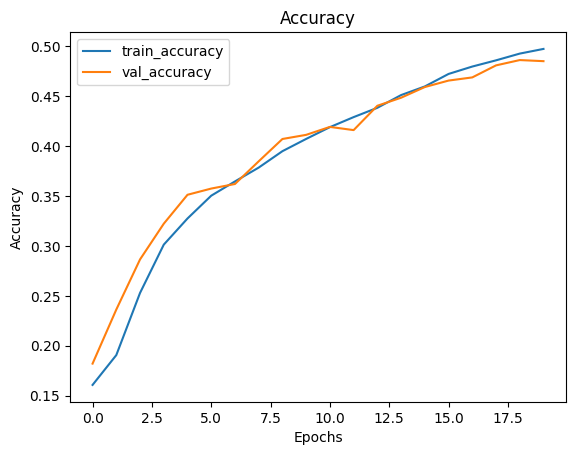

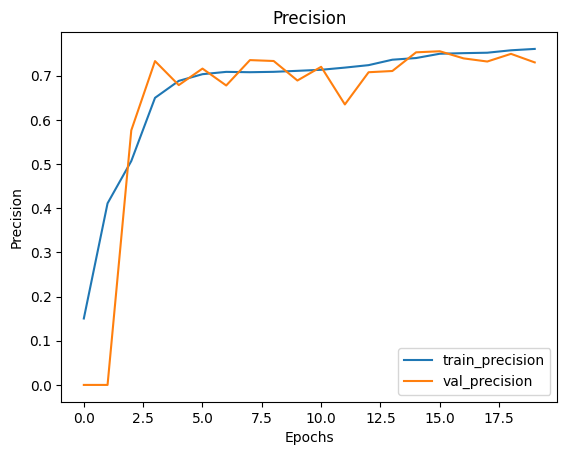

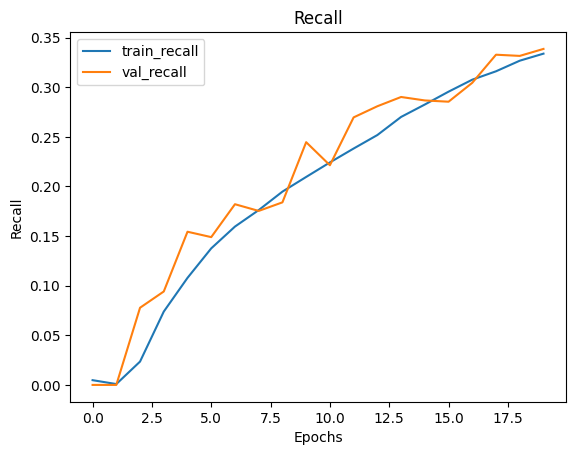

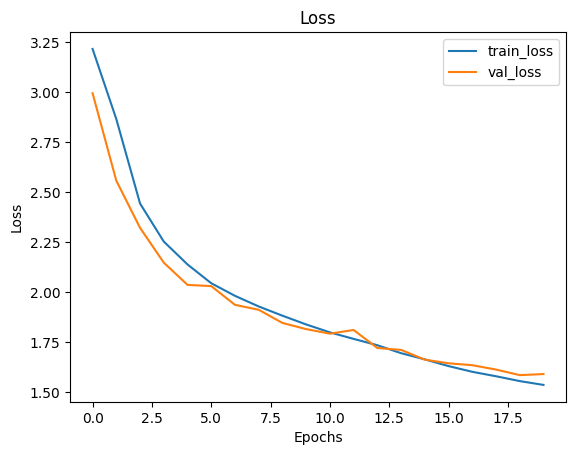

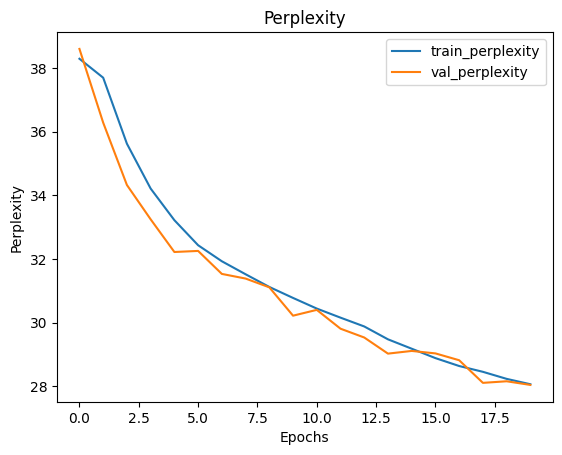

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'loss', 'perplexity']

    for metric in metrics:
        plt.plot(history.history[metric], label=f"train_{metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f"{metric.capitalize()}")
        plt.show()

plot_metrics(history)

The performance tends to improve compared to the previous model, but the best model remains with 30 as the `maxlen` and 3 as the `step`.

# Final Model and Testing on Similar Text

For the model architecture, I am using the one that achieved the best performance (specifically, the fourth model), while maintaining the same hyperparameters (with `maxlen` for max sequence length and a `step` size of 3). In terms of generalization, it is the model with the best performance and the strongest generalization capabilities.

As a test set, we use *Vita Nuova*, another work by Dante. Specifically, we focus only on the poetic compositions, excluding the prose, to ensure that the texts are as similar as possible to *Divina Commedia*. Of course, the compositions have very different structures, even within the same text, but since the author is the same, it provides a good basis for model evaluation and comparison.

In [ ]:
maxlen = 30
step = 3

In [ ]:
sentences_train = []
next_chars_train = []

for i in range(0, len(training_text) - maxlen, step):
    sentences_train.append(training_text[i: i + maxlen])
    next_chars_train.append(training_text[i + maxlen])

In [ ]:
sentences_val = []
next_chars_val = []

for i in range(0, len(validation_text) - maxlen, step):
    sentences_val.append(validation_text[i: i + maxlen])
    next_chars_val.append(validation_text[i + maxlen])

In [ ]:
def vectorize_data(sentences, next_chars, char_indices, maxlen, len_chars):
    x = np.zeros((len(sentences), maxlen, len_chars), dtype=bool)
    y = np.zeros((len(sentences), len_chars), dtype=bool)

    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
    return x, y

x_train, y_train = vectorize_data(sentences_train, next_chars_train, char_indices, maxlen, len(chars))
x_val, y_val = vectorize_data(sentences_val, next_chars_val, char_indices, maxlen, len(chars))

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(146094, 30, 40)
(146094, 40)
(39996, 30, 40)
(39996, 40)


In [ ]:
model = Sequential([
    Input(shape=(maxlen, len(chars))),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(len(chars), activation='softmax')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy',
                                                                             kmetrics.Precision(name="precision"),
                                                                             kmetrics.Recall(name="recall"),
                                                                             perplexity])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 30, 512)             │         608,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405,992 (5.36 MB)

 Trainable params: 1,405,992 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=2048,
    epochs=20,
    callbacks=[print_callback]
)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.1285 - loss: 3.4339 - perplexity: 38.5548 - precision: 0.0959 - recall: 0.0039

******* Epoch: 1 ********
***** starting sentence *****
mio segnore;
  <<fatti sicur, 
*****************************
mio segnore;
  <<fatti sicur,                                                                                                                                                                                                                                                                                                                                                                                                                 
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 614ms/step - accuracy: 0.1288 - loss: 3.4302 - perplexity: 38.5512 - precision: 0.0960 - recall: 0.0039 - val_accuracy: 0.1820 - val_loss: 2.9686 - val_perplexity: 38.1723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/ste

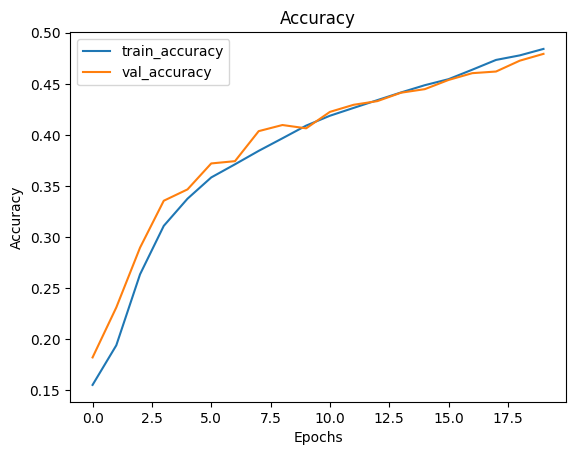

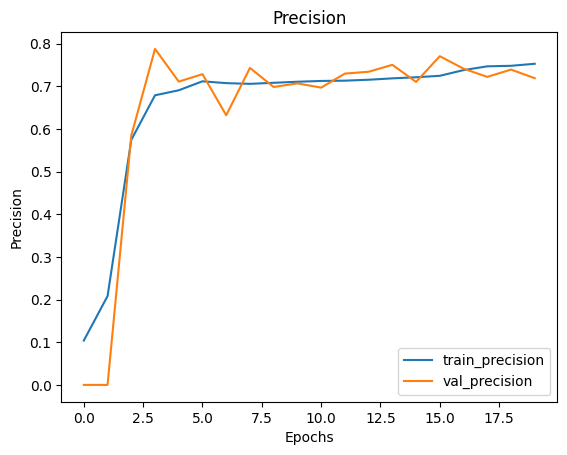

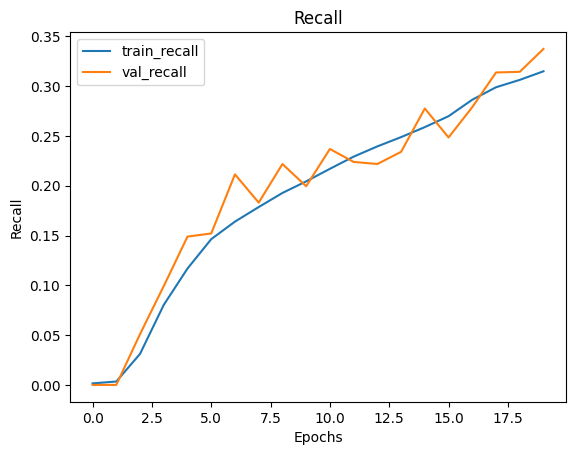

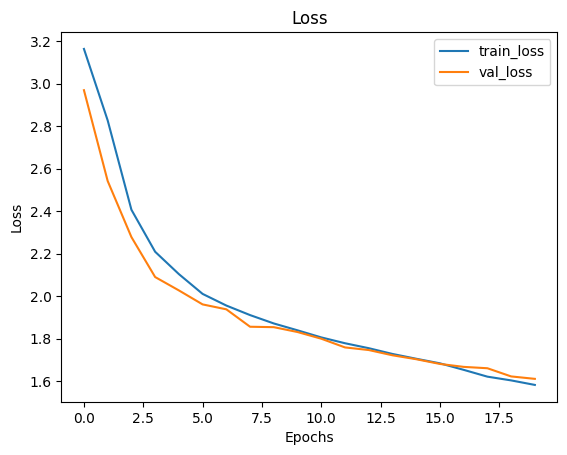

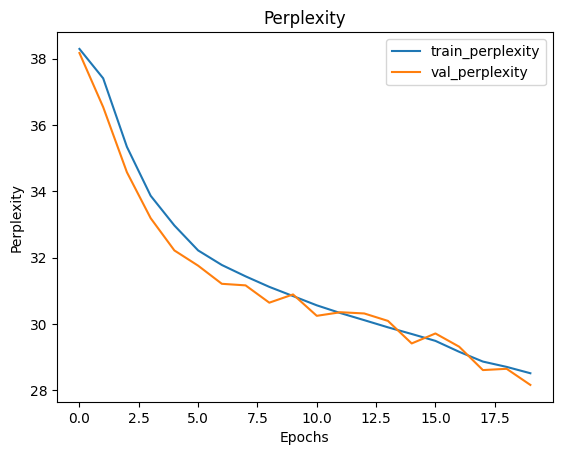

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'loss', 'perplexity']

    for metric in metrics:
        plt.plot(history.history[metric], label=f"train_{metric}")
        plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.title(f"{metric.capitalize()}")
        plt.show()

plot_metrics(history)

In [ ]:
vita_nuova_path = '/content/drive/MyDrive/Vita Nova.txt'
with io.open(vita_nuova_path, encoding='utf-8') as f:
    vita_nuova_text = f.read().lower()

vita_nuova_text = vita_nuova_text.replace('ò', 'o`')
vita_nuova_text = vita_nuova_text.replace('à', 'a`')
vita_nuova_text = vita_nuova_text.replace('è', 'e`')
vita_nuova_text = vita_nuova_text.replace('ù', 'u`')
vita_nuova_text = vita_nuova_text.replace('ì', 'i`')
vita_nuova_text = vita_nuova_text.replace('ê', 'e')
vita_nuova_text = vita_nuova_text.replace('î', 'i')
vita_nuova_text = vita_nuova_text.replace('ï', 'i')
vita_nuova_text = vita_nuova_text.replace('â', 'a')
vita_nuova_text = vita_nuova_text.replace('ô', 'o')


print('text length (vita nuova):', len(vita_nuova_text))
print('\n\n\n\n\n', '****** first 1000 characters of Vita Nuova *******', '\n\n\n\n')
print(vita_nuova_text[:1000])

text length (vita nuova): 24359





 ****** first 1000 characters of Vita Nuova ******* 




a ciascun'alma presa e gentil core,
nel cui cospetto viene il dir presente,
a cio` che mi riscrivan suo parvente,
salute in lor signor, cioe` amore.

gia` eran quasi ch'atterzate l'ore
del tempo ch'ogni stella n'e` lucente,
quando m'apparve amor subitamente,
cui essenza membrar mi da` orrore.

allegro mi sembrava amor, tenendo
mio core in mano, e nelle braccia avea
madonna, involta in un drappo, dormendo.

poi la svegliava, e d'esto core ardendo
lei paventosa umilmente pascea:
appresso gir lo ne vedea piangendo.



o voi, che per la via d'amor passate,
attendete, e guardate
s'egli e` dolore alcun, quanto il mio, grave:
e priego sol, ch'udir mi sofferiate;
e poi imaginate
s'io son d'ogni dolore ostello e chiave.

amor, non gia` per mia poca bontate,
ma per sua nobiltate,
mi pose in vita si` dolce e soave,
ch'i' mi sentia dir dietro spesse fiate:
deh! per qual dignitate
cosi` leggiadro questi lo

In [ ]:
sentences_vita = []
next_chars_vita = []

for i in range(0, len(vita_nuova_text) - maxlen, step):
    sentences_vita.append(vita_nuova_text[i: i + maxlen])
    next_chars_vita.append(vita_nuova_text[i + maxlen])

print('Number of sequences (Vita Nuova):', len(sentences_vita))

Number of sequences (Vita Nuova): 8110


In [ ]:
x_vita, y_vita = vectorize_data(sentences_vita, next_chars_vita, char_indices, maxlen, len(chars))


In [ ]:
evaluation = model.evaluate(x_vita, y_vita, batch_size=2048)
print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Precision: {evaluation[2]}")
print(f"Recall: {evaluation[3]}")
print(f"Perplexity: {evaluation[4]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4184 - loss: 2.0231 - perplexity: 29.7930 - precision: 0.6048 - recall: 0.2719
Loss: 1.9990155696868896
Accuracy: 0.42244142293930054
Precision: 0.6154478192329407
Recall: 0.27706533670425415
Perplexity: 29.663909912109375


After experimentation and fine-tuning, the model trained on Divina Commedia and evaluated on Vita Nuova shows a mixed performance. While the results in terms of accuracy (42.24%) and loss (1.999) indicate that the model has learned some useful patterns from the training data, it still struggles with generalization to the Vita Nuova text. The perplexity remains relatively high (29.66), indicating some uncertainty in its predictions, and the recall (27.71%) suggests that the model is missing a substantial portion of the true positives, which points to limitations in its ability to capture the diversity of the Vita Nuova language and structure.

In [ ]:
start_index = np.random.randint(0, len(vita_nuova_text) - maxlen - 1)
original_text = vita_nuova_text[start_index: start_index + maxlen]

generated_text = original_text
print(f"Original seed: {original_text}")

for _ in range(200):
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(generated_text[-maxlen:]):
        if char in char_indices:
            x_pred[0, t, char_indices[char]] = 1.0

    predictions = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(predictions)
    next_char = chars[next_index]

    generated_text += next_char

print("\n\nOriginal Text:")
print(vita_nuova_text[start_index: start_index + 200])
print("\n\nGenerated Text:")
print(generated_text)


Original seed: ta` fuora,
visi di donne m'app


Original Text:
ta` fuora,
visi di donne m'apparver crucciati,
che mi dicean pur: morra'ti, morra'ti.

poi vidi cose dubitose molte
nel vano imaginare, ov'io entrai;
ed esser mi parea non so in qual loco,
e veder don


Generated Text:
ta` fuora,
visi di donne m'appar che si stanne
  che si stanno e di segue e di segno,
  che si stanno e di segue e di segno,
  che si stanno e di segue e di segno,
  che si stanno e di segue e di segno,
  che si stanno e di segue 
